# p3. Support Vector Machine


- 기수: 11기

- 이름: 한은결

- 작성자: 11기 김정우

본 과제 문제에서는 간단한 SVM 실습을 Support Vector Machine의 개념과 Kernel SVM과 Naive SVM의 차이에 대해 이해하는 것을 목표로 한다.

### 01. Setting

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix

from sklearn import datasets # to use iris dataset from scikit-learn.datasets

In [2]:
iris = datasets.load_iris()

In [3]:
# Use pandas dataframe for visualization
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names) 
iris_df['target'] = iris.target

print(iris_df.shape)
iris_df.head(-1)

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
144,6.7,3.3,5.7,2.5,2
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2


In [4]:
iris_df.shape

(150, 5)

In [5]:
X = iris.data[:, [0, 2]]  # use only sepal length and petal length
y = iris.target

# Binary Classification Task (setosa or not)
y = np.where(y == 0, 0, 1)

In [6]:
print("Data Shape:", X.shape)

Data Shape: (150, 2)


### 02. Naive SVM

간단한 SVM을 직접 구현해보자! (편의를 위해 Sepal Length와 Petal Length 2개의 변수만을 이용해 Setosa 여부를 판단하는 Binary Classification 문제로 간주한다.)

SVM에서 기본 Condition은 $\text{condition} = y_{idx} \cdot (\mathbf{w} \cdot \mathbf{x_i} - b) \geq 1$ 으로 정의할 수 있다.

만약 Margin의 바깥쪽에 있을 때, 즉 Condition이 참이면 $\mathbf{w} \leftarrow \mathbf{w} - \eta (2 \lambda \mathbf{w})$ 이 되며, 거짓이면 $\mathbf{w} \leftarrow \mathbf{w} - \eta (2 \lambda \mathbf{w} - y_{idx} \mathbf{x_i})$ 이 된다.

Bias는 $\mathbf{w} \leftarrow \mathbf{w} - \eta (2 \lambda \mathbf{w})$ 와 같이 업데이트 할 수 있다.

실제 예측 시에는 $y = \mathbf{X} \cdot \mathbf{w} - b$ 와 같이 학습된 Weight와 Bias를 이용하여 예측을 수행할 수 있다.

In [7]:
# Simple SVM Class
class SimpleSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=32):
        self.learning_rate = learning_rate  # learning rate for weight update
        self.lambda_param = lambda_param    # normalization factor for weight 
        self.n_iters = n_iters              # train iteration
        self.w = None                       # model weight
        self.b = None                       # model bias


    def fit(self, X, y):
        n_features = X.shape[1]     # Eqaul to the number of data point
        y_ = 2*y-1           # Translate label from [0, 1] into [-1, +1]

        self.w = np.zeros(n_features)           # Weight Initialization
        self.b = 0                              # Bias Initialization

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(self.w, x_i) - self.b) >= 1
                if condition:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - y_[idx] * x_i)
                    self.b -= self.learning_rate * (-1) * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        predictions = np.sign(approx)
        return np.where(predictions == -1, 0, 1)


In [8]:
# Train/Test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [9]:
# Model Training
SVM = SimpleSVM()
SVM.fit(X_train, y_train)

In [10]:
# Prediction
y_pred = SVM.predict(X_test)

In [11]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM 모델의 정확도: {accuracy * 100:.2f}%")

SVM 모델의 정확도: 100.00%


In [12]:
# Meshgrid function
def make_meshgrid(x, y, h=0.01):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# Countour function
def plot_contours(ax, model, xx, yy, **params):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

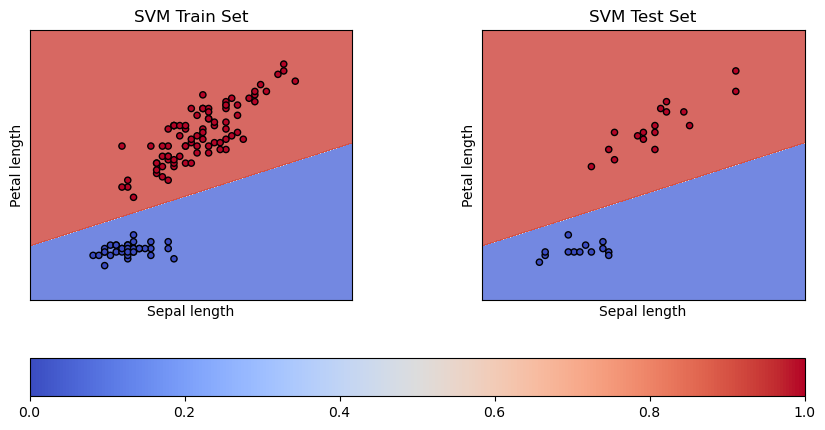

In [13]:
# Contour plot
fig, sub = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

titles = ['SVM Train Set', 'SVM Test Set']
datasets = [(X_train, y_train), (X_test, y_test)]

for (X_set, y_set), title, ax in zip(datasets, titles, sub.flatten()):
    plot_contours(ax, SVM, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    scatter = ax.scatter(X_set[:, 0], X_set[:, 1], c=y_set, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Petal length')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig.colorbar(scatter, ax=sub, orientation='horizontal')
plt.show()

### 03. Kernel PCA

직접 Linear PCA와 Kernel PCA의 차이를 시각화해서 살펴보도록 하겠다. 구현의 편의를 위해 여기서부턴 라이브러리가 지원하는 SVM을 사용하자!

*03번 Section에서는 별도로 수정할 코드가 없습니다. 직접 실행해보고 결과를 확인해보세요!*

In [15]:
#iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

In [16]:
C = 1   # SVM의 regularization parameter

clf = svm.SVC(kernel="linear", C=C)
clf.fit(X,y)

y_pred = clf.predict(X)
confusion_matrix(y, y_pred)

array([[50,  0,  0],
       [ 0, 38, 12],
       [ 0, 15, 35]], dtype=int64)

In [17]:
# LinearSVM
clf_linear = svm.LinearSVC(C=C, max_iter=1000)   
clf_linear.fit(X, y)

y_pred = clf_linear.predict(X)
confusion_matrix(y, y_pred)

C:\Users\ekhan\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\ekhan\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([[49,  1,  0],
       [ 2, 30, 18],
       [ 0,  9, 41]], dtype=int64)

*참고: LinearSVC와 SVC의 linear kernel을 사용하는 것은 loss function에 있어 약간의 차이가 존재한다고 한다.*

In [18]:
# RBF KernelPCA
clf_rbf = svm.SVC(kernel='rbf', gamma=0.7, C=C, max_iter=1000)   # gamma: scale parameter
clf_rbf.fit(X, y)

y_pred = clf_rbf.predict(X)
confusion_matrix(y, y_pred)

array([[50,  0,  0],
       [ 0, 37, 13],
       [ 0, 13, 37]], dtype=int64)

In [19]:
# Polynomial KernelPCA
clf_pol = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C, max_iter=1000)
clf_pol.fit(X,y)

y_pred = clf_pol.predict(X)
confusion_matrix(y, y_pred)

C:\Users\ekhan\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


array([[50,  0,  0],
       [ 0, 31, 19],
       [ 0, 13, 37]], dtype=int64)

해당 결과들을 시각화하면 아래와 같다.

In [20]:
C = 1.0 
models = (clf, clf_linear, clf_pol, clf_rbf)
models = (clf.fit(X, y) for clf in models)

# plot title 형성
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

C:\Users\ekhan\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\ekhan\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ekhan\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


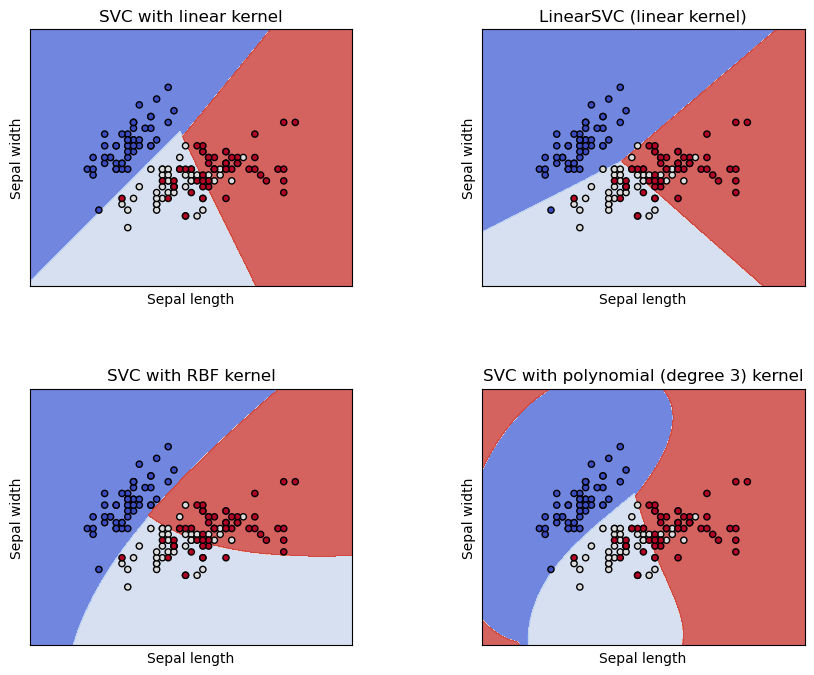

In [21]:
fig, sub = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()